# Vintage Analysis in Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from operator import attrgetter

import seaborn as sns
import matplotlib.ticker as mtick


pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

credit = pd.read_csv("credit_record.csv.zip").drop('Unnamed: 0', axis=1, errors='ignore')
# lowercase the columns name, not mandatory but it easier to user lowercase columns name
credit.columns = credit.columns.str.lower()

# Convert date columns to datetime format
credit['start_date'] = pd.to_datetime(credit['start_date'])
credit['snapshot_month'] = pd.to_datetime(credit['snapshot_month'])
credit.head()

,id,status,start_date,snapshot_month
0,5001711,0,2022-09-01,2022-09-01
1,5001711,0,2022-09-01,2022-10-01
2,5001711,0,2022-09-01,2022-11-01
3,5001711,X,2022-09-01,2022-12-01
4,5001712,0,2021-06-01,2021-06-01


## Data Exploration

In [2]:
## Calculate value of each columns
print("Unique values ==> ")
credit.apply(lambda x: x.nunique())

#Unique values ==>

# id                45971
# status                8
# start_date           61
# snapshot_month       61
# dtype: int64

print(credit[['start_date', 'snapshot_month']].describe())

#                           start_date                 snapshot_month
# count                        1048174                        1048174
# mean   2019-12-22 14:52:08.361512704  2021-04-27 14:19:30.918569472
# min              2017-12-01 00:00:00            2017-12-01 00:00:00
# 25%              2018-12-01 00:00:00            2020-07-01 00:00:00
# 50%              2019-11-01 00:00:00            2021-07-01 00:00:00
# 75%              2020-12-01 00:00:00            2022-05-01 00:00:00
# max              2022-12-01 00:00:00            2022-12-01 00:00:00

Unique values ==> 
                          start_date                 snapshot_month
count                        1048174                        1048174
mean   2019-12-22 14:52:08.361512704  2021-04-27 14:19:30.918569472
min              2017-12-01 00:00:00            2017-12-01 00:00:00
25%              2018-12-01 00:00:00            2020-07-01 00:00:00
50%              2019-11-01 00:00:00            2021-07-01 00:00:00
75%              2020-12-01 00:00:00            2022-05-01 00:00:00
max              2022-12-01 00:00:00            2022-12-01 00:00:00


In [3]:
## Calculate value of each columns
print("Missing values ==> ")
credit.apply(lambda x: x.isnull().sum())

# Missing values values ==> 
# id                0
# status            0
# start_date        0
# snapshot_month    0
# dtype: int64

Missing values ==> 


id                0
status            0
start_date        0
snapshot_month    0
dtype: int64

## Data Preparation

In [4]:
## Past due flag
credit['is_30_past_due'] = np.where(credit['status'].isin(['1', '2', '3','4', '5']), 1, 0)
credit['is_60_past_due'] = np.where(credit['status'].isin(['2', '3','4', '5']), 1, 0)
credit['is_90_past_due'] = np.where(credit['status'].isin(['3','4', '5']), 1, 0)

## Convert to quarter
credit['start_quarter'] = credit['start_date'].dt.to_period('Q')
credit['snapshot_quarter'] =credit['snapshot_month'].dt.to_period('Q')

In [5]:
## Calculate the number of users

number_of_user = credit.groupby(['start_quarter'])['id'].nunique().reset_index()
number_of_user = number_of_user.rename(columns = {'id':'n_user'})

## Calcuate the cummulative sum of past due case
credit_summary = credit.groupby(['start_quarter', 'snapshot_quarter'])[['is_30_past_due', 'is_60_past_due', 'is_90_past_due']].agg(
                {'is_30_past_due':'sum', 'is_60_past_due':'sum', 'is_90_past_due':'sum'}).reset_index()

credit_summary['cumsum_30'] = credit_summary.sort_values(['start_quarter','snapshot_quarter'],ascending=True).groupby(['start_quarter'])['is_30_past_due'].cumsum()
credit_summary['cumsum_60'] = credit_summary.sort_values(['start_quarter','snapshot_quarter'],ascending=True).groupby(['start_quarter'])['is_60_past_due'].cumsum()
credit_summary['cumsum_90'] = credit_summary.sort_values(['start_quarter','snapshot_quarter'],ascending=True).groupby(['start_quarter'])['is_90_past_due'].cumsum()

credit_summary = credit_summary.merge(number_of_user, on = 'start_quarter', how = 'left')

## get the bad percentage

credit_summary['bad_30'] = credit_summary['cumsum_30']/credit_summary['n_user']
credit_summary['bad_60'] = credit_summary['cumsum_60']/credit_summary['n_user']
credit_summary['bad_90'] = credit_summary['cumsum_90']/credit_summary['n_user']

credit_summary['n_quarter'] = (credit_summary['snapshot_quarter'] - credit_summary['start_quarter']).apply(attrgetter('n'))

credit_summary_lim = credit_summary[(credit_summary['start_quarter'] > '2018Q4') &
                (credit_summary['start_quarter'] < '2021Q4') ]



## Vintage analysis table and graph

In [6]:
vint30 = credit_summary_lim.pivot(index='start_quarter', columns='n_quarter', values='bad_30').round(3).fillna('')
vint60 = credit_summary_lim.pivot(index='start_quarter', columns='n_quarter', values='bad_60').round(3).fillna('')
vint90 = credit_summary_lim.pivot(index='start_quarter', columns='n_quarter', values='bad_90').round(3).fillna('') 

vint90

n_quarter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
start_quarter,,,,,,,,,,,,,,,,
2019Q1,0.000,0.002,0.007,0.014,0.020,0.025,0.028,0.032,0.036,0.039,0.045,0.048,0.051,0.054,0.056,0.059
2019Q2,0.001,0.002,0.007,0.013,0.021,0.031,0.038,0.043,0.049,0.055,0.06,0.065,0.072,0.078,0.084,
2019Q3,0.000,0.003,0.009,0.018,0.025,0.032,0.036,0.039,0.043,0.049,0.054,0.058,0.065,0.069,,
2019Q4,0.000,0.000,0.003,0.009,0.019,0.027,0.034,0.043,0.054,0.057,0.06,0.064,0.07,,,
2020Q1,0.000,0.000,0.000,0.004,0.011,0.020,0.029,0.037,0.042,0.046,0.048,0.052,,,,
2020Q2,0.000,0.002,0.005,0.012,0.020,0.029,0.037,0.044,0.05,0.056,0.061,,,,,
2020Q3,0.000,0.000,0.001,0.003,0.008,0.012,0.014,0.018,0.019,0.021,,,,,,
2020Q4,0.000,0.002,0.006,0.010,0.015,0.020,0.025,0.03,0.033,,,,,,,
2021Q1,0.000,0.001,0.003,0.010,0.018,0.023,0.026,0.029,,,,,,,,


/tmp/ipykernel_23350/4167916082.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


Text(0.5, 1.0, 'Bad Rate Overdue payment > 30 days')

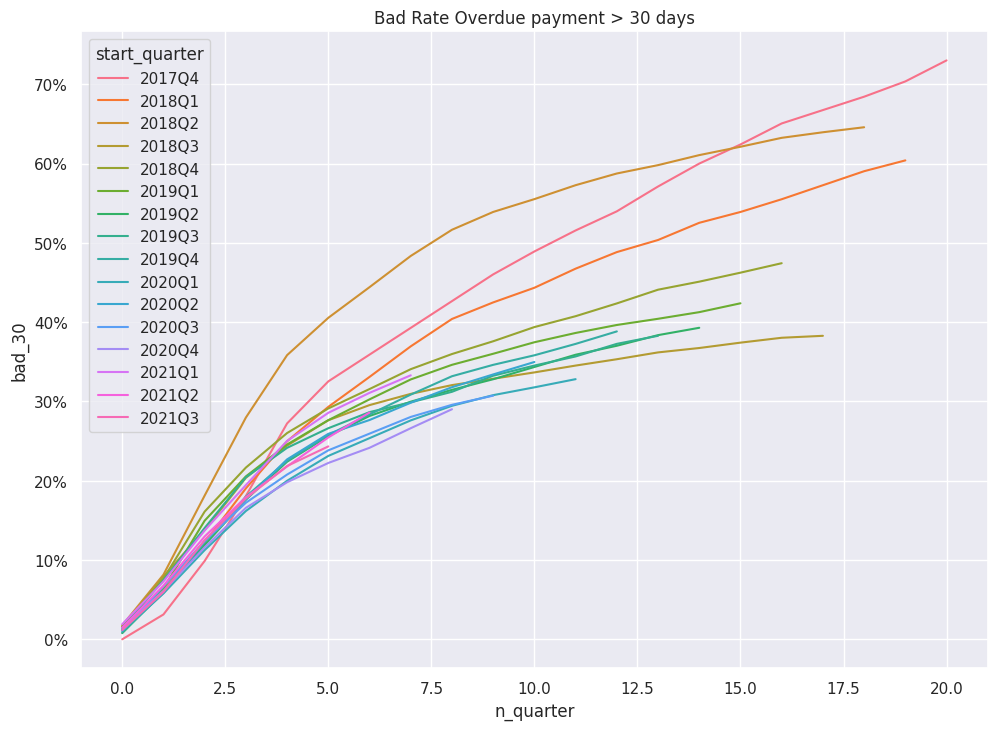

In [7]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


credit_summary_lim = credit_summary[
                (credit_summary['start_quarter'] < '2021Q4') ]

ax = sns.lineplot(x = 'n_quarter', y = 'bad_30', hue= 'start_quarter', data = credit_summary_lim)#.set_title("Bad Rate Overdue payment > 30 days")

# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title("Bad Rate Overdue payment > 30 days")

/tmp/ipykernel_23350/223337908.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


Text(0.5, 1.0, 'Bad Rate Overdue payment > 60 days')

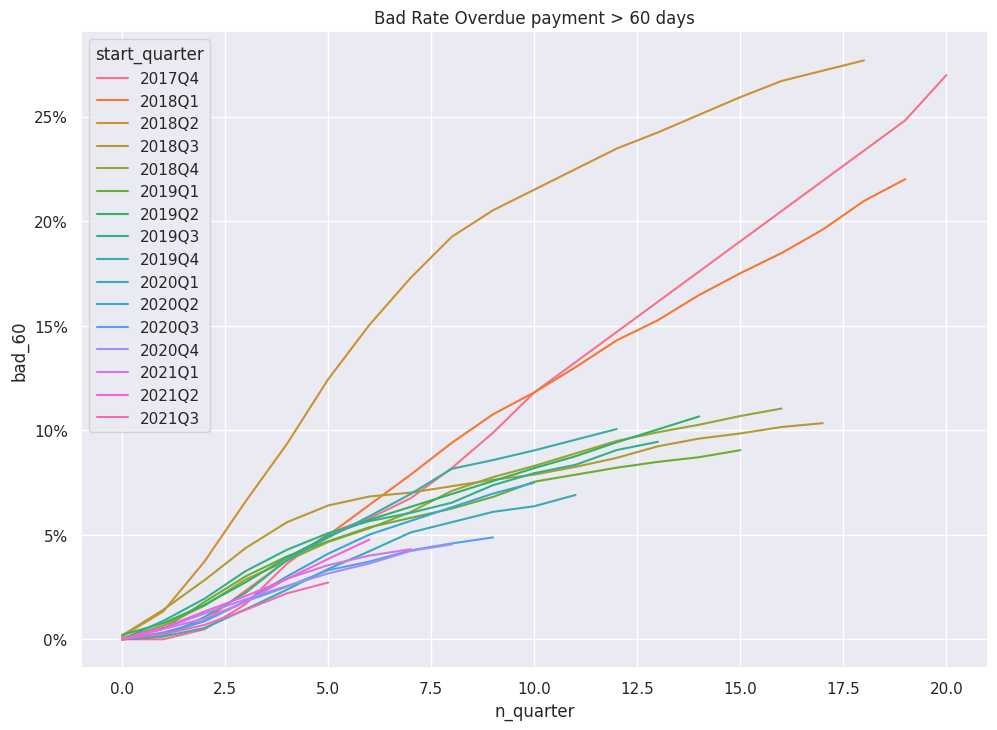

In [8]:
ax = sns.lineplot(x = 'n_quarter', y = 'bad_60', hue= 'start_quarter', data = credit_summary_lim)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title("Bad Rate Overdue payment > 60 days")

/tmp/ipykernel_23350/1882662261.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


Text(0.5, 1.0, 'Bad Rate Overdue payment > 90 days')

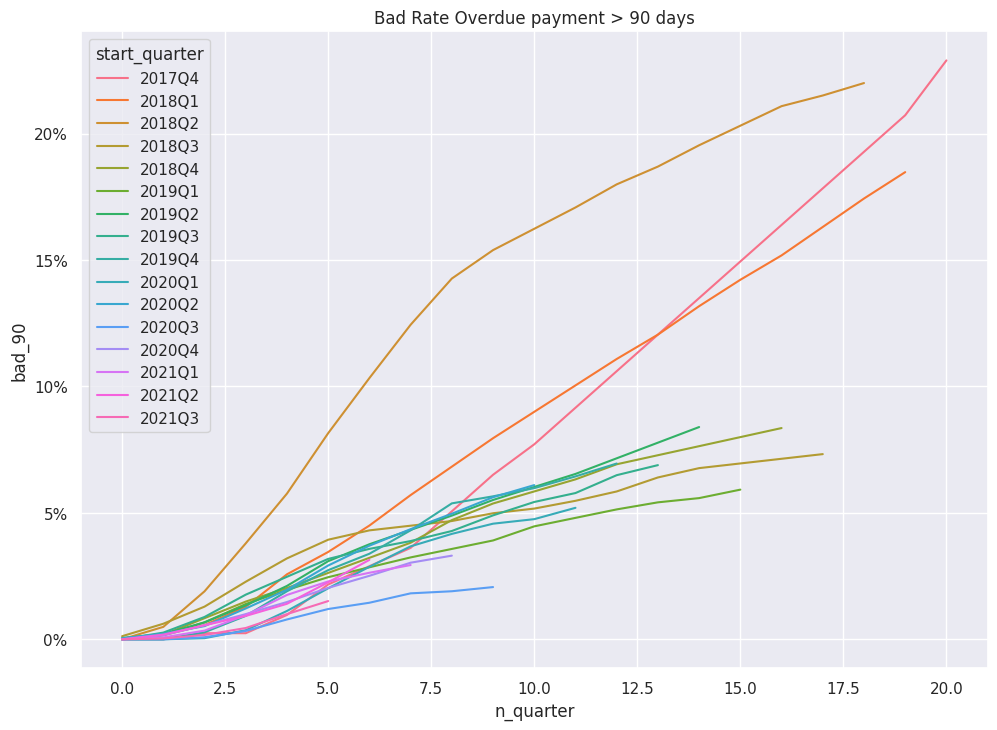

In [9]:
ax = sns.lineplot(x = 'n_quarter', y = 'bad_90', hue= 'start_quarter', data = credit_summary_lim)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title("Bad Rate Overdue payment > 90 days")